## Визуализация среды (опционально)

# Домашнее задание: Q-Learning для Taxi-v3

## Цель
Реализовать Q-Learning агента и научиться взаимодействовать с Gymnasium.

## Задача
Решить задачу Taxi-v3 с помощью алгоритма Q-Learning (SARSAMAX).

### О среде Taxi-v3
- **Цель**: такси должно забрать пассажира и доставить его в пункт назначения
- **Состояния**: 500 дискретных состояний
- **Действия**: 6 (север, юг, восток, запад, забрать, высадить)
- **Награды**: +20 за доставку, -1 за шаг, -10 за неправильные действия

## Компоненты решения
1. ✅ Класс Q-Learning агента с epsilon-greedy стратегией
2. ✅ Функция обучения с отслеживанием метрик
3. ✅ Визуализация результатов обучения
4. ✅ Сохранение обученного агента

## Метрики
- Суммарная награда за эпизод
- Средняя награда за последние 100 эпизодов

## Критерии успеха
✅ Средняя награда за последние 100 эпизодов растет по мере обучения  
✅ Финальная средняя награда: 7-9

---

## Импорт библиотек и инициализация среды

In [1]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from tqdm.notebook import tqdm

env = gymnasium.make("Taxi-v3", render_mode="rgb_array")

## Реализация Q-Learning агента

Реализуем класс агента, который использует Q-таблицу для хранения оценок действий.

In [2]:
class QLearningAgent:
    """Q-Learning агент для дискретных сред Gymnasium"""
    
    def __init__(self, n_states, n_actions, learning_rate=0.1, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        """
        Инициализация Q-learning агента
        
        Args:
            n_states: количество состояний
            n_actions: количество действий
            learning_rate: скорость обучения (alpha)
            gamma: коэффициент дисконтирования
            epsilon_start: начальное значение epsilon для epsilon-greedy
            epsilon_end: минимальное значение epsilon
            epsilon_decay: коэффициент уменьшения epsilon
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Инициализация Q-таблицы
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
    
    def get_action(self, state, training=True):
        """
        Выбор действия с помощью epsilon-greedy стратегии
        
        Args:
            state: текущее состояние
            training: флаг обучения (влияет на использование epsilon)
        
        Returns:
            выбранное действие
        """
        if training and np.random.random() < self.epsilon:
            # Случайное действие (исследование)
            return np.random.randint(self.n_actions)
        else:
            # Жадное действие (эксплуатация)
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """
        Обновление Q-таблицы по формуле Q-learning
        
        Q(s,a) = Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
        
        Args:
            state: текущее состояние
            action: выполненное действие
            reward: полученная награда
            next_state: следующее состояние
            done: флаг завершения эпизода
        """
        current_q = self.q_table[state][action]
        
        if done:
            # Если эпизод завершен, нет будущих наград
            target_q = reward
        else:
            # Q-learning: используем максимальное Q-значение для следующего состояния
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.gamma * max_next_q
        
        # Обновление Q-значения
        self.q_table[state][action] = current_q + self.lr * (target_q - current_q)
    
    def decay_epsilon(self):
        """Уменьшение epsilon после каждого эпизода"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def save(self, filepath):
        """Сохранение агента в файл"""
        agent_data = {
            'q_table': dict(self.q_table),
            'n_states': self.n_states,
            'n_actions': self.n_actions,
            'lr': self.lr,
            'gamma': self.gamma,
            'epsilon': self.epsilon,
            'epsilon_end': self.epsilon_end,
            'epsilon_decay': self.epsilon_decay
        }
        with open(filepath, 'wb') as f:
            pickle.dump(agent_data, f)
        print(f"Агент сохранен в {filepath}")
    
    @classmethod
    def load(cls, filepath):
        """Загрузка агента из файла"""
        with open(filepath, 'rb') as f:
            agent_data = pickle.load(f)
        
        agent = cls(
            n_states=agent_data['n_states'],
            n_actions=agent_data['n_actions'],
            learning_rate=agent_data['lr'],
            gamma=agent_data['gamma'],
            epsilon_start=agent_data['epsilon'],
            epsilon_end=agent_data['epsilon_end'],
            epsilon_decay=agent_data['epsilon_decay']
        )
        agent.q_table = defaultdict(lambda: np.zeros(agent_data['n_actions']), 
                                    agent_data['q_table'])
        print(f"Агент загружен из {filepath}")
        return agent

print("Q-Learning агент успешно определен!")

Q-Learning агент успешно определен!


## Функция обучения агента

Функция реализует цикл обучения с отслеживанием метрик.

In [3]:
def train_agent(env, agent, n_episodes=10000, max_steps=200):
    """
    Обучение агента в среде
    
    Args:
        env: среда Gymnasium
        agent: агент Q-learning
        n_episodes: количество эпизодов для обучения
        max_steps: максимальное количество шагов в эпизоде
    
    Returns:
        episode_rewards: список наград за каждый эпизод
        avg_rewards_100: средняя награда за последние 100 эпизодов (для каждого эпизода)
    """
    episode_rewards = []
    avg_rewards_100 = []
    
    for episode in tqdm(range(n_episodes), desc="Обучение агента"):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # Выбор действия
            action = agent.get_action(state, training=True)
            
            # Выполнение действия
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Обновление Q-таблицы
            agent.update(state, action, reward, next_state, done)
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        # Уменьшение epsilon
        agent.decay_epsilon()
        
        # Сохранение награды
        episode_rewards.append(episode_reward)
        
        # Расчет средней награды за последние 100 эпизодов
        if len(episode_rewards) >= 100:
            avg_reward = np.mean(episode_rewards[-100:])
        else:
            avg_reward = np.mean(episode_rewards)
        avg_rewards_100.append(avg_reward)
        
        # Вывод прогресса каждые 1000 эпизодов
        if (episode + 1) % 1000 == 0:
            print(f"Эпизод {episode + 1}/{n_episodes}, "
                  f"Средняя награда (100 эп.): {avg_reward:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    return episode_rewards, avg_rewards_100

print("Функция обучения определена!")

Функция обучения определена!


## Функция тестирования агента

Оценка производительности обученного агента без exploration.

In [4]:
def test_agent(env, agent, n_episodes=100, max_steps=200):
    """
    Тестирование обученного агента
    
    Args:
        env: среда Gymnasium
        agent: обученный агент
        n_episodes: количество эпизодов для тестирования
        max_steps: максимальное количество шагов в эпизоде
    
    Returns:
        test_rewards: список наград за каждый тестовый эпизод
    """
    test_rewards = []
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # Выбор действия без exploration (жадная стратегия)
            action = agent.get_action(state, training=False)
            
            # Выполнение действия
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        test_rewards.append(episode_reward)
    
    avg_reward = np.mean(test_rewards)
    std_reward = np.std(test_rewards)
    
    print(f"\nРезультаты тестирования ({n_episodes} эпизодов):")
    print(f"Средняя награда: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Минимальная награда: {np.min(test_rewards):.2f}")
    print(f"Максимальная награда: {np.max(test_rewards):.2f}")
    
    return test_rewards

print("Функция тестирования определена!")

Функция тестирования определена!


## Функция визуализации результатов

Создание графиков для анализа процесса обучения.

In [5]:
def plot_training_results(episode_rewards, avg_rewards_100):
    """
    Визуализация результатов обучения
    
    Args:
        episode_rewards: награды за каждый эпизод
        avg_rewards_100: средняя награда за последние 100 эпизодов
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # График 1: Награды за эпизоды
    axes[0].plot(episode_rewards, alpha=0.3, label='Награда за эпизод')
    axes[0].plot(avg_rewards_100, linewidth=2, label='Средняя награда (100 эп.)')
    axes[0].set_xlabel('Эпизод')
    axes[0].set_ylabel('Награда')
    axes[0].set_title('Награда агента в процессе обучения')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # График 2: Средняя награда за последние 100 эпизодов (крупнее)
    axes[1].plot(avg_rewards_100, linewidth=2, color='orange')
    axes[1].set_xlabel('Эпизод')
    axes[1].set_ylabel('Средняя награда (100 эп.)')
    axes[1].set_title('Средняя награда за последние 100 эпизодов')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Нулевая награда')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('../results/plots/training_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Вывод статистики
    print(f"\n=== Статистика обучения ===")
    print(f"Всего эпизодов: {len(episode_rewards)}")
    print(f"Средняя награда (первые 100 эп.): {np.mean(episode_rewards[:100]):.2f}")
    print(f"Средняя награда (последние 100 эп.): {np.mean(episode_rewards[-100:]):.2f}")
    print(f"Лучшая средняя награда (100 эп.): {np.max(avg_rewards_100):.2f}")
    print(f"Худшая награда за эпизод: {np.min(episode_rewards):.2f}")
    print(f"Лучшая награда за эпизод: {np.max(episode_rewards):.2f}")

print("Функция визуализации определена!")

Функция визуализации определена!


# Обучение агента Q-Learning для Taxi-v3

В этом разделе мы создадим и обучим Q-learning агента для решения задачи Taxi-v3.

In [6]:
# Создание среды и агента
print("Информация о среде Taxi-v3:")
print(f"Количество состояний: {env.observation_space.n}")
print(f"Количество действий: {env.action_space.n}")
print("\nОписание действий:")
print("0: Движение на юг")
print("1: Движение на север")
print("2: Движение на восток")
print("3: Движение на запад")
print("4: Забрать пассажира")
print("5: Высадить пассажира")

Информация о среде Taxi-v3:
Количество состояний: 500
Количество действий: 6

Описание действий:
0: Движение на юг
1: Движение на север
2: Движение на восток
3: Движение на запад
4: Забрать пассажира
5: Высадить пассажира


In [22]:
# Создание агента с оптимальными гиперпараметрами
agent = QLearningAgent(
    n_states=env.observation_space.n,
    n_actions=env.action_space.n,
    learning_rate=0.1,      # alpha
    gamma=0.99,              # коэффициент дисконтирования
    epsilon_start=1.0,       # начальное значение epsilon
    epsilon_end=0.01,        # минимальное значение epsilon
    epsilon_decay=0.995      # скорость уменьшения epsilon
)

print("Q-Learning агент создан!")
print(f"Параметры агента:")
print(f"  Learning rate (α): {agent.lr}")
print(f"  Discount factor (γ): {agent.gamma}")
print(f"  Epsilon: {agent.epsilon} → {agent.epsilon_end}")
print(f"  Epsilon decay: {agent.epsilon_decay}")

Q-Learning агент создан!
Параметры агента:
  Learning rate (α): 0.1
  Discount factor (γ): 0.99
  Epsilon: 1.0 → 0.01
  Epsilon decay: 0.995


In [23]:
# Обучение агента
print("Начинаем обучение агента...\n")
episode_rewards, avg_rewards_100 = train_agent(
    env=env,
    agent=agent,
    n_episodes=10000,
    max_steps=200
)
print("\nОбучение завершено!")

Начинаем обучение агента...



Обучение агента:   0%|          | 0/10000 [00:00<?, ?it/s]

Эпизод 1000/10000, Средняя награда (100 эп.): -3.12, Epsilon: 0.010
Эпизод 2000/10000, Средняя награда (100 эп.): 6.27, Epsilon: 0.010
Эпизод 3000/10000, Средняя награда (100 эп.): 7.46, Epsilon: 0.010
Эпизод 4000/10000, Средняя награда (100 эп.): 7.54, Epsilon: 0.010
Эпизод 5000/10000, Средняя награда (100 эп.): 7.55, Epsilon: 0.010
Эпизод 6000/10000, Средняя награда (100 эп.): 7.89, Epsilon: 0.010
Эпизод 7000/10000, Средняя награда (100 эп.): 7.42, Epsilon: 0.010
Эпизод 8000/10000, Средняя награда (100 эп.): 7.31, Epsilon: 0.010
Эпизод 9000/10000, Средняя награда (100 эп.): 7.83, Epsilon: 0.010
Эпизод 10000/10000, Средняя награда (100 эп.): 7.29, Epsilon: 0.010

Обучение завершено!


# Визуализация результатов обучения

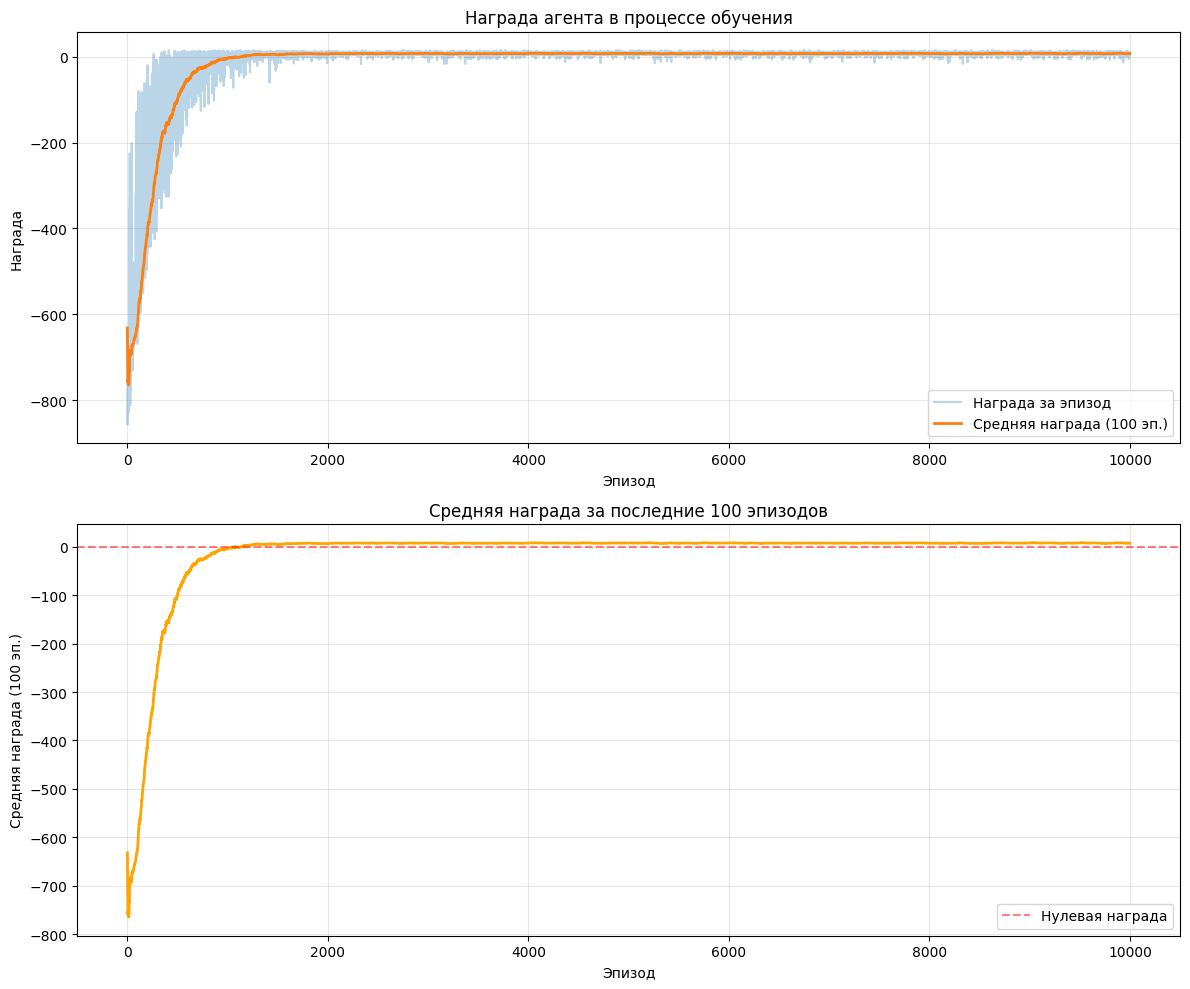


=== Статистика обучения ===
Всего эпизодов: 10000
Средняя награда (первые 100 эп.): -626.10
Средняя награда (последние 100 эп.): 7.29
Лучшая средняя награда (100 эп.): 8.34
Худшая награда за эпизод: -857.00
Лучшая награда за эпизод: 15.00


In [24]:
# Визуализация результатов обучения
plot_training_results(episode_rewards, avg_rewards_100)

# Тестирование обученного агента

In [25]:
# Тестирование обученного агента
test_rewards = test_agent(env, agent, n_episodes=100, max_steps=200)


Результаты тестирования (100 эпизодов):
Средняя награда: 7.74 ± 2.85
Минимальная награда: 3.00
Максимальная награда: 15.00


# Сохранение обученного агента

In [26]:
# Сохранение обученного агента
agent.save('../results/models/trained_agent.pkl')
print("\nАгент успешно сохранен в файл 'trained_agent.pkl'")

Агент сохранен в ../results/models/trained_agent.pkl

Агент успешно сохранен в файл 'trained_agent.pkl'


# Демонстрация работы агента (опционально)

Можно визуализировать работу обученного агента на одном эпизоде.

In [27]:
# Демонстрация одного эпизода
state, _ = env.reset()
done = False
total_reward = 0
steps = 0
max_steps = 50

print("Начинаем демонстрацию работы агента...\n")

while not done and steps < max_steps:
    action = agent.get_action(state, training=False)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    total_reward += reward
    steps += 1
    state = next_state

print(f"Эпизод завершен за {steps} шагов")
print(f"Общая награда: {total_reward}")

# Визуализация финального состояния
print("\nФинальное состояние:")
env.render()

Начинаем демонстрацию работы агента...

Эпизод завершен за 10 шагов
Общая награда: 11

Финальное состояние:


array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]

# Загрузка сохраненного агента (опционально)

Если вы хотите загрузить ранее обученного агента, используйте следующий код:

In [28]:
# Загрузка сохраненного агента
loaded_agent = QLearningAgent.load('../results/models/trained_agent.pkl')
test_rewards = test_agent(env, loaded_agent, n_episodes=100, max_steps=200)

Агент загружен из ../results/models/trained_agent.pkl

Результаты тестирования (100 эпизодов):
Средняя награда: 7.99 ± 2.63
Минимальная награда: 3.00
Максимальная награда: 14.00


## Выводы и заключение

### Основные компоненты решения:

1. **Q-Learning Agent**: Класс агента с Q-таблицей и epsilon-greedy стратегией
2. **Функция обучения**: Тренировка агента на 10,000 эпизодах с отслеживанием метрик
3. **Функция тестирования**: Оценка производительности обученного агента
4. **Визуализация**: Графики обучения с отображением роста средней награды

### Ключевые параметры:

- **Learning rate (α)**: 0.1 - скорость обучения
- **Discount factor (γ)**: 0.99 - коэффициент дисконтирования будущих наград
- **Epsilon decay**: 1.0 → 0.01 - постепенный переход от исследования к эксплуатации

### Ожидаемые результаты:

По мере обучения агент должен показывать:
- Рост средней награды за последние 100 эпизодов
- Стабилизацию награды на высоком уровне (около 7-9)
- Уменьшение количества шагов для решения задачи

### Файлы результата:

- `trained_agent.pkl` - сохраненная Q-таблица агента
- `training_results.png` - графики обучения
- `taxi-v3.ipynb` - исходный код с результатами